In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/Uni/UniPD/HumanDataProject/Code'

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code


In [31]:
import sys
import seaborn as sns
import pandas as pd
import os
import numpy as np
from config import PREPROCESSING_PATH ,DATASET_SPLIT_PATH
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io import wavfile
import matplotlib.pyplot as plt



from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [4]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 19.3 MB/s eta 0:00:00


In [5]:
sys.path.append(PREPROCESSING_PATH)

In [6]:
import preprocessing_tf

In [7]:
print("Number of GPU:", len(tf.config.list_physical_devices('GPU')))
print("Version:", tf.__version__)

Number of GPU: 1
Version: 2.15.0


# Dataset Loading

loading dataset to runtime as reading it from the drive slows down the model pipeline

In [8]:
%cd /content/drive/MyDrive/Uni/UniPD/HumanDataProject

/content/drive/MyDrive/Uni/UniPD/HumanDataProject


In [9]:
!unzip project_data_split.zip -d /content/data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/data/project_data_split/validation/off/439c84f4_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_3.wav 

In [10]:
#DATASET_SPLIT_PATH = "/content/data/project_data_split"

# Create train and validation dataset

Construct dataframes that includes the file paths and the corresponding spoken command (label) for each audio sample. The dataset comprises audio samples of 25 keywords: `backward`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `learn`, `left`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `six`, `stop`, `three`, `two`, `up`, `visual`, `yes`, `zero`. Additionally, it contains 10 words `bed`,`bird`,`cat`, `dog`,`happy`,`house`,`marvin`,`sheila`,`tree`,`wow` that the model should not recognize as keywords.

To facilitate model training and evaluation, the labels are appropriately mapped: labels corresponding to the 25 keywords are retained in their original form, signifying that these are the commands the model is expected to recognize. Conversely, the labels for the 10 non-keyword words are mapped to a single class named "unknown". This approach consolidates these distinct non-keyword labels into a single category, simplifying the model's task by reducing the classification scope to the keywords and an "unknown" class for any non-keyword utterances.

In [11]:
train_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"train"))
val_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"validation"))

In [12]:
train_df.head()

,filepath,label,mapped_label
0,/content/data/project_data_split/train/off/f05...,off,off
1,/content/data/project_data_split/train/off/214...,off,off
2,/content/data/project_data_split/train/off/c1e...,off,off
3,/content/data/project_data_split/train/off/919...,off,off
4,/content/data/project_data_split/train/off/05c...,off,off


In [13]:
file_paths = tf.constant(train_df['filepath'].values)
labels = tf.constant(train_df['mapped_label'].values)

In [14]:
# Create a StringLookup layer
#label_lookup = label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup = tf.keras.layers.StringLookup()
label_lookup.adapt(labels)
# Transform labels into numeric
numeric_labels = label_lookup(labels)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((file_paths, numeric_labels))

In [15]:
file_paths_val = tf.constant(val_df['filepath'].values)
labels_val = tf.constant(val_df['mapped_label'].values)
numeric_labels_val = label_lookup(labels_val)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_paths_val, numeric_labels_val))

# Preprocessing the Datasets

The training and validation datasets undergo preprocessing through our established pipeline. For the baseline model, the preprocessing involves two steps: padding the data to ensure uniformity in size, which is essential for the model's input requirements, and converting the audio files into spectrograms.

In [16]:
#With parameters
#train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,resample=True,mfcc=True),
#                               num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)


val_spectrogram_ds = validation_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)

Data shape: (None,)
Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)
Final shape: (124, 129, 1)
Data shape: (None,)
Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)
Final shape: (124, 129, 1)


In [17]:
batch_size = 32
train_spectrogram_ds = train_spectrogram_ds.batch(batch_size)
val_spectrogram_ds = val_spectrogram_ds.batch(batch_size)

In [18]:
input_shape =train_spectrogram_ds.element_spec[0].shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_lookup.get_vocabulary())
print('Number of labels:', num_labels)

Input shape: (124, 129, 1)
Number of labels: 27


# Model

The baseline model adopted for our analysis originates from the TensorFlow tutorial designed for a mini version of the speech dataset https://www.tensorflow.org/tutorials/audio/simple_audio. This model serves primarily as a benchmark for comparison purposes. Our objective is to demonstrate that subsequent models, which incorporate more intricate architectures or employ additional preprocessing steps, will surpass the performance of this baseline model.

In [19]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [20]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [23]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
2652/2652 [==============================] - 52s 16ms/step - loss: 1.5749 - accuracy: 0.5484 - val_loss: 2.5889 - val_accuracy: 0.3613
Epoch 2/10
2652/2652 [==============================] - 41s 15ms/step - loss: 0.8909 - accuracy: 0.7280 - val_loss: 2.2160 - val_accuracy: 0.4578
Epoch 3/10
2652/2652 [==============================] - 27s 10ms/step - loss: 0.6960 - accuracy: 0.7864 - val_loss: 1.8099 - val_accuracy: 0.5250
Epoch 4/10
2652/2652 [==============================] - 37s 14ms/step - loss: 0.6038 - accuracy: 0.8146 - val_loss: 1.5968 - val_accuracy: 0.5869
Epoch 5/10
2652/2652 [==============================] - 27s 10ms/step - loss: 0.5559 - accuracy: 0.8286 - val_loss: 1.7311 - val_accuracy: 0.5407
Epoch 6/10
2652/2652 [==============================] - 36s 14ms/step - loss: 0.5102 - accuracy: 0.8419 - val_loss: 1.9469 - val_accuracy: 0.5320
Epoch 6: early stopping


# Evaluation
The model's performance on our test dataset is assessed using the top-1 error rate, which is the same metric employed by the dataset's creator.

In [24]:
test_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"test"))
file_paths_test = tf.constant(test_df['filepath'].values)
labels_test = tf.constant(test_df['mapped_label'].values)
numeric_labels_test = label_lookup(labels_test)
test_dataset = tf.data.Dataset.from_tensor_slices((file_paths_test, numeric_labels_test))


In [25]:
test_spectrogram_ds = test_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)

Data shape: (None,)
Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)
Final shape: (124, 129, 1)


In [26]:
batch_size = 32
test_spectrogram_ds = test_spectrogram_ds.batch(batch_size)

In [27]:
predictions = model.predict(test_spectrogram_ds)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)
accuracy = np.mean(predicted_classes == true_labels)

print(f"Manual Test Accuracy: {accuracy}")

# Calculate the Top-1 Error Rate
top_1_error_rate = 1 - accuracy
print(f"Manual Top-1 Error Rate: {top_1_error_rate}")

344/344 [==============================] - 19s 53ms/step
Manual Test Accuracy: 0.521308496138119
Manual Top-1 Error Rate: 0.478691503861881


In [28]:
# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_classes, average='macro')
recall = recall_score(true_labels, predicted_classes, average='macro')
f1 = f1_score(true_labels, predicted_classes, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7333213376518296
Recall: 0.5172034651585602
F1 Score: 0.4776572556595822


In [29]:
# Generate and visualize confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

In [34]:
# Assuming `label_lookup` is your StringLookup layer already adapted to your labels
vocabulary = label_lookup.get_vocabulary()

# Function to convert numeric labels to string labels
def numeric_to_string_labels(numeric_labels):
    return np.array(vocabulary)[numeric_labels]

# Convert true labels and predicted classes to their string representations
true_labels_strings = numeric_to_string_labels(true_labels)
predicted_classes_strings = numeric_to_string_labels(predicted_classes)

unique_labels_strings = np.unique(np.concatenate([true_labels_strings, predicted_classes_strings]))


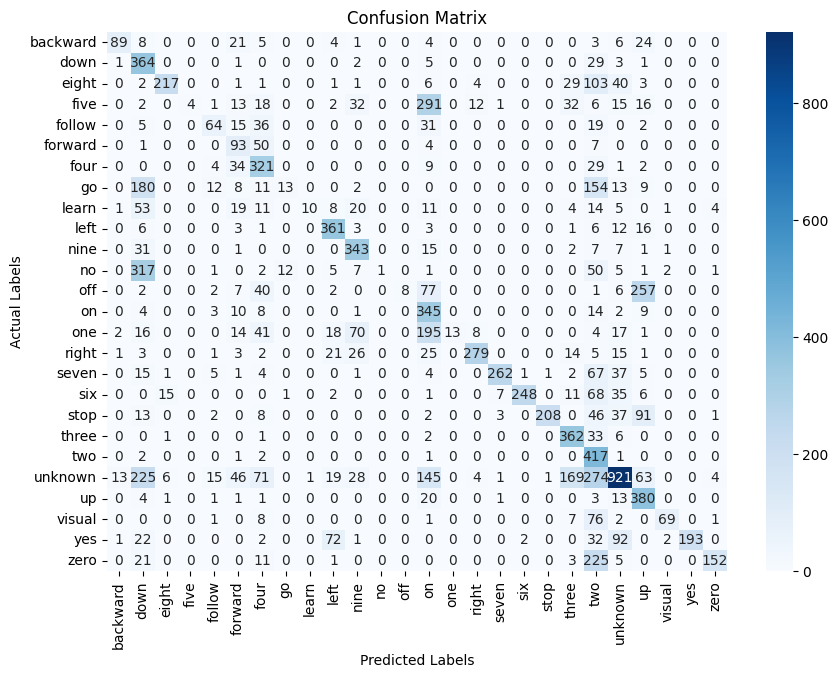

In [37]:
conf_matrix = confusion_matrix(true_labels_strings, predicted_classes_strings, labels=unique_labels_strings)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_strings, yticklabels=unique_labels_strings)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()